<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/DocBank_Detectron2_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DocBank - Inference using Detectron2

DocBank is a new large-scale dataset that is constructed using a weak supervision approach. It enables models to integrate both the textual and layout information for downstream tasks. The current DocBank dataset totally includes 500K document pages.

In this notebook we test the DocBank Detectron2 trained model.

## Install

In [ ]:
# install dependencies: 
!pip install "pyyaml==5.1" "pycocotools>=2.0.1"
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

## Import

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Get model

DocBank has a list of pretrained models using the dataset. This models are available in the [Model Zoo website](https://github.com/doc-analysis/DocBank/blob/master/MODEL_ZOO.md).

To upload it to google colab I am going to use my google drive. To do that, previously I downloaded the model and I uploded to my google drive.

In this notebook we are going to use the `X101` model. This is a Detectron2 model.

NOTE: the list of labels are available in [this link](https://github.com/doc-analysis/DocBank/blob/master/labels.txt)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp /content/drive/MyDrive/models/X101.zip .
!unzip X101.zip
!ls X101

Archive:  X101.zip
   creating: X101/
  inflating: X101/model.pth          
  inflating: X101/X101.yaml          
model.pth  X101.yaml


The detectron2 models need a configuration file. The problem is this configuration depends on the `Base-RCNN-FPN` configuration. 

In [6]:
!cat X101/X101.yaml

_BASE_: "../../configs/Base-RCNN-FPN.yaml"
MODEL:
  WEIGHTS: "detectron2://ImageNetPretrained/FAIR/X-101-32x8d.pkl"
  MASK_ON: False
  PIXEL_STD: [57.375, 57.120, 58.395]
  RESNETS:
    STRIDE_IN_1X1: False  # this is a C2 model
    NUM_GROUPS: 32
    WIDTH_PER_GROUP: 8
    DEPTH: 101
  ROI_HEADS:
    NUM_CLASSES: 13
SOLVER:
  STEPS: (84000, 94500)
  MAX_ITER: 105000
  IMS_PER_BATCH: 48
  BASE_LR: 0.06
DATASETS:
  TRAIN: ("docbank_seg_train",)
  TEST: ("docbank_seg_test",)
DATALOADER:
  NUM_WORKERS: 2
OUTPUT_DIR: "X101"


To overcome this dependency, I going to create the `Base-RCNN-FPN` file in my directory and to change the dependency path.

In [10]:
# Create the Base-RCNN-FPN.yaml in the model directory
f = open("X101/Base-RCNN-FPN.yaml", "a")
f.write("""
MODEL:
  META_ARCHITECTURE: "GeneralizedRCNN"
  BACKBONE:
    NAME: "build_resnet_fpn_backbone"
  RESNETS:
    OUT_FEATURES: ["res2", "res3", "res4", "res5"]
  FPN:
    IN_FEATURES: ["res2", "res3", "res4", "res5"]
  ANCHOR_GENERATOR:
    SIZES: [[32], [64], [128], [256], [512]]  # One size for each in feature map
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]  # Three aspect ratios (same for all in feature maps)
  RPN:
    IN_FEATURES: ["p2", "p3", "p4", "p5", "p6"]
    PRE_NMS_TOPK_TRAIN: 2000  # Per FPN level
    PRE_NMS_TOPK_TEST: 1000  # Per FPN level
    # Detectron1 uses 2000 proposals per-batch,
    # (See "modeling/rpn/rpn_outputs.py" for details of this legacy issue)
    # which is approximately 1000 proposals per-image since the default batch size for FPN is 2.
    POST_NMS_TOPK_TRAIN: 1000
    POST_NMS_TOPK_TEST: 1000
  ROI_HEADS:
    NAME: "StandardROIHeads"
    IN_FEATURES: ["p2", "p3", "p4", "p5"]
  ROI_BOX_HEAD:
    NAME: "FastRCNNConvFCHead"
    NUM_FC: 2
    POOLER_RESOLUTION: 7
  ROI_MASK_HEAD:
    NAME: "MaskRCNNConvUpsampleHead"
    NUM_CONV: 4
    POOLER_RESOLUTION: 14
DATASETS:
  TRAIN: ("coco_2017_train",)
  TEST: ("coco_2017_val",)
SOLVER:
  IMS_PER_BATCH: 16
  BASE_LR: 0.02
  STEPS: (60000, 80000)
  MAX_ITER: 90000
INPUT:
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
VERSION: 2
""")
f.close()

In [48]:
# Change the dependency path
!sed -i 's\../../configs/\./\g' X101/X101.yaml

In [9]:
!cat X101/X101.yaml

_BASE_: "./Base-RCNN-FPN.yaml"
MODEL:
  WEIGHTS: "detectron2://ImageNetPretrained/FAIR/X-101-32x8d.pkl"
  MASK_ON: False
  PIXEL_STD: [57.375, 57.120, 58.395]
  RESNETS:
    STRIDE_IN_1X1: False  # this is a C2 model
    NUM_GROUPS: 32
    WIDTH_PER_GROUP: 8
    DEPTH: 101
  ROI_HEADS:
    NUM_CLASSES: 13
SOLVER:
  STEPS: (84000, 94500)
  MAX_ITER: 105000
  IMS_PER_BATCH: 48
  BASE_LR: 0.06
DATASETS:
  TRAIN: ("docbank_seg_train",)
  TEST: ("docbank_seg_test",)
DATALOADER:
  NUM_WORKERS: 2
OUTPUT_DIR: "X101"


In [11]:
!ls X101

Base-RCNN-FPN.yaml  model.pth  X101.yaml


## Get test image

This models use as input an image of document page.

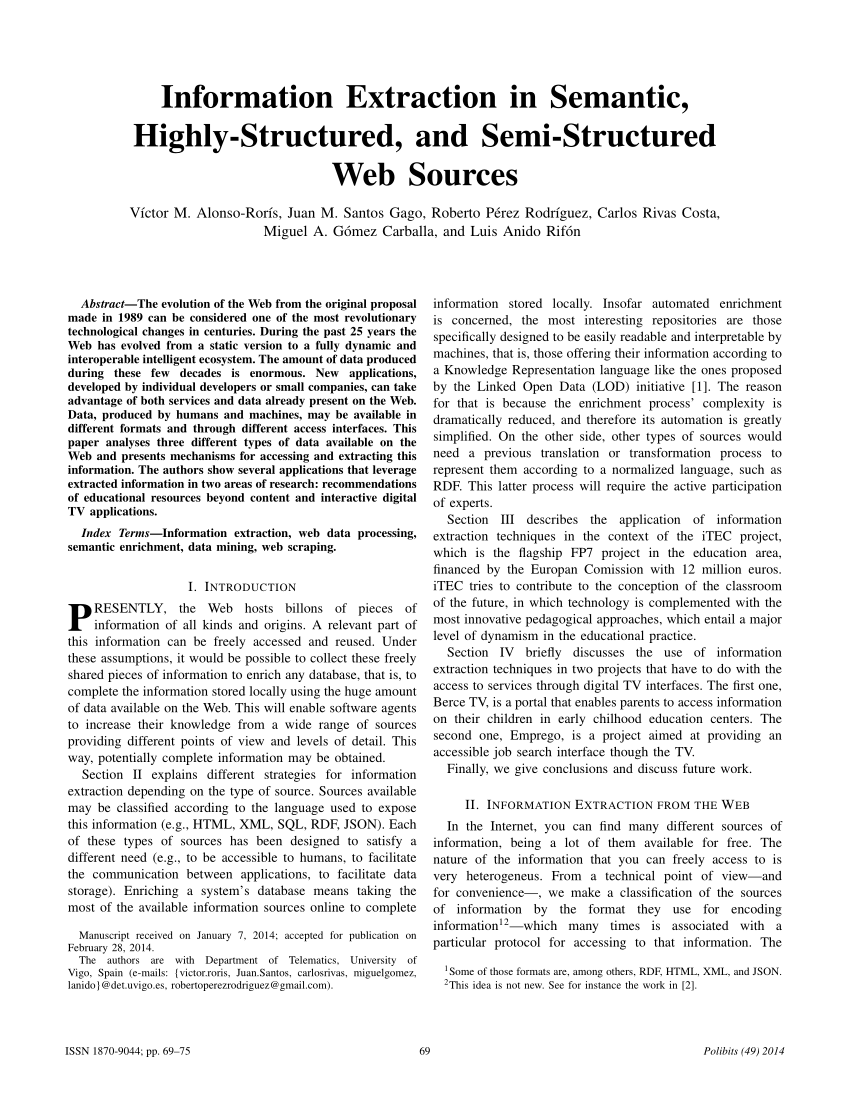

In [12]:
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# !wget https://i1.rgstatic.net/publication/316448042_Machine_Learning_With_Big_Data_Challenges_and_Approaches/links/5915a79d4585152e199f5b4f/largepreview.png -q -O input.jpg
!wget https://i1.rgstatic.net/publication/265172391_Information_Extraction_in_Semantic_Highly-Structured_and_Semi-Structured_Web_Sources/links/5d9a4cb3a6fdccfd0e7ef333/largepreview.png -q -O input.jpg
# !wget https://raw.githubusercontent.com/doc-analysis/DocBank/master/DocBank_samples/DocBank_samples/10.tar_1701.04170.gz_TPNL_afterglow_evo_8.jpg -q -O input.jpg
# !wget https://raw.githubusercontent.com/doc-analysis/DocBank/master/DocBank_samples/DocBank_samples/100.tar_1705.04261.gz_main_11.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

## Prediction

Detectron2 instructions are available in https://github.com/facebookresearch/detectron2

In [16]:
cfg = get_cfg()
cfg.merge_from_file("X101/X101.yaml")
cfg.MODEL.WEIGHTS = os.path.join("X101/model.pth") 
predictor = DefaultPredictor(cfg)

In [17]:
outputs = predictor(im)

In [24]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].scores)
print(outputs["instances"].pred_boxes)

tensor([ 8,  8,  0,  8, 10, 10,  8,  8, 12,  8,  6,  8,  8,  6,  1,  1,  8, 10,
         1], device='cuda:0')
tensor([0.9993, 0.9990, 0.9980, 0.9978, 0.9978, 0.9975, 0.9964, 0.9953, 0.9931,
        0.9908, 0.9885, 0.9858, 0.9846, 0.9811, 0.9634, 0.2863, 0.1279, 0.0670,
        0.0613], device='cuda:0')
Boxes(tensor([[ 417.6719, 1042.4309,  429.4813, 1055.7758],
        [ 431.1840,  295.4717,  780.2104,  775.1014],
        [  67.4092,  292.5136,  414.1453,  516.7250],
        [  65.9170,  588.1509,  415.2364,  913.2974],
        [ 463.7783,  794.9864,  747.5612,  810.8978],
        [ 185.2509,  576.7438,  294.0166,  592.7204],
        [  81.1962,  293.8759,  133.7820,  309.0356],
        [ 431.8866,  816.2441,  780.2026,  948.4313],
        [ 131.6856,   73.7840,  714.4860,  190.1464],
        [ 702.8804, 1042.9664,  783.1434, 1055.7931],
        [ 444.2438,  962.3870,  779.2283,  989.4557],
        [  64.2933, 1043.1495,  189.2898, 1055.9618],
        [  66.9710,  522.3186,  414.6801, 

Visualize the segment predictions

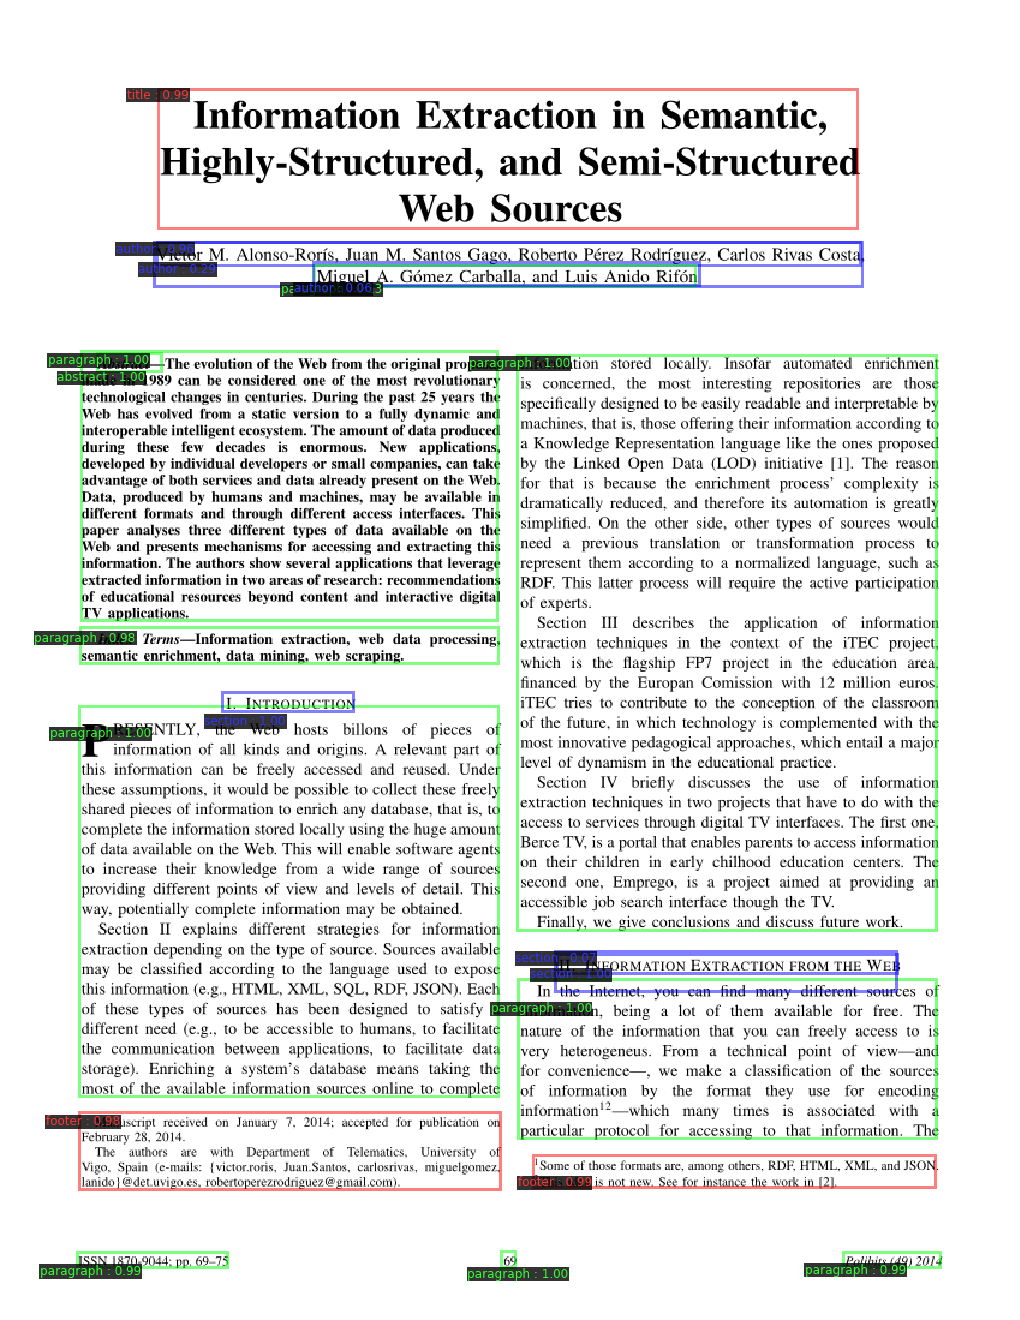

In [47]:
# We can use `Visualizer` to draw the predictions on the image.
labels = ["abstract", "author", "caption", "date", "equation",
                          "figure", "footer", "list", "paragraph", "reference",
                          "section", "table", "title"]

metacat = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes = labels
v = Visualizer(im[:, :, ::-1], metacat, scale=1.2)

# # -- Standard visualization
# out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow(out.get_image()[:, :, ::-1])

# -- Custom visualization
def random_color():
    rgbl=[1,0,0]
    random.shuffle(rgbl)
    return tuple(rgbl)

def move_label_position(pos):
  n = random.randint(0,20)
  pos_0 = pos[0] + n
  pos_1 = pos[1] + n
  return (pos_0,pos_1)


cls_colors = {}
for idx, box in enumerate(outputs["instances"].pred_boxes.to('cpu')):

    # Visualization data
    digit = outputs['instances'].scores.tolist()[idx]
    sdigit = "{:.2f}".format(digit)
    clas = outputs["instances"].pred_classes.tolist()[idx]
    if clas not in cls_colors:
        cls_colors[clas] = random_color()
    color = cls_colors[clas]
    label = labels[clas]
    label_position=move_label_position(tuple(box[:2].numpy()))
    
    v.draw_box(box, edge_color=color)
    v.draw_text(f"{label} : {sdigit}", label_position, color=color)
v = v.get_output()
img =  v.get_image()[:, :, ::-1]
cv2_imshow(img)